In [1]:
using Revise

In [2]:
using PyCall, PyPlot
using ClimateMARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");

┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1260


In [16]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Utils
using ClimateMARGO.Optimization
using ClimateMARGO.IO

### Replicating Belaia, Moreno-Cruz, and Keith (2020 preprint) results

Loading in the default model parameters

In [17]:
params = included_configurations["default"]

ClimateModelParameters("Belaia_et_al_2020", Domain(1.0, 2020.0, 2020.0, 2500.0), Economics(100.0, 0.02, 0.0022222222222222222, 0.03, 7.5, 0.02871536194333177, 13.0, 0.125, 4.5, 0.0, 0, nothing, nothing, [4.481434058898847, 4.583354673495518, 4.684250960307298, 4.7841229193341865, 4.882970550576184, 4.98079385403329, 5.077592829705505, 5.173367477592828, 5.268117797695262, 5.361843790012803  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 5.35, 1.13, 42.400000000000006, 0.146, 0.625))

#### Modifications to match Belaia et al. DICE configuration

In [18]:
# Shorter timestep, longer timeframe
params.domain.dt = 1.
params.domain.final_year = 2500.

# Slightly higher discount rate
params.economics.ρ = 0.015;

# Modify cost parameters
params.economics.mitigate_cost = (200. * 70.e9 / 1.e12) / E(params)[t(params).==2100][1];
params.economics.Finf = 7.5
params.economics.geoeng_cost = params.economics.β * (params.economics.Finf^2);

# Remove assumption of no present-day geoengineering
params.economics.geoeng_init = nothing

# Remove initial condition on mitigation
params.economics.mitigate_init = 0.0

# Modify baseline emissions scenario (Figure 4 https://arxiv.org/abs/1903.02043)
function baseline_emissions_Belaia(params)
    q = zeros(size(t(params)))
    q[t(params).<=2120.] = (
        GtCO2_to_ppm(75.) .- GtCO2_to_ppm(40.) * ( (t(params)[t(params).<=2120.] .- 2120.) ./ 100.).^2
    )
    q[t(params).>2120.] = (
        GtCO2_to_ppm(75.) .- GtCO2_to_ppm(30.) * ( (t(params)[t(params).>2120.] .- 2120.) ./ 130.).^2.
    )
    q[q .< 0] .= 0.
    return q
end
params.economics.baseline_emissions = baseline_emissions_Belaia(params);

# Modify physical parameters to better approximate DICE EBM (see Calel 2016 in BAMS for details)
params.physics.a = 5.35;
params.physics.Cd *= 0.4
params.physics.κ *= 0.2

# Needed to increase airborne fraction of CO2 to match DICE carbon cycle
params.physics.r *= 1.25

params.name = "Belaia_et_al_2020";

In [19]:
Belaia = ClimateModel(params);

#### Modifications to optimization constraints

In [20]:
# Remove limit on how early deployments can be
delay_deployment=Dict("remove"=>0., "mitigate"=>0., "geoeng"=>0., "adapt"=>0.)

# Modify cost functions exponents
cost_exponent = Dict("mitigate" => 1.8, "geoeng" => 2., "adapt" => 0., "remove" => 1.1)

# Much higher intertia in deployment rates, except geoengineering which has virtually no limit
slope = 1. /90
max_slope = Dict("mitigate" => slope, "geoeng" => 1., "adapt" => slope, "remove" => slope);

## Run optimization

In [21]:
Belaia = ClimateModel(params);
optimize_controls!(
    Belaia,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>1., "mitigate"=>1., "geoeng"=>1., "adapt"=>0.), # no adaptation
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Belaia_MR = ClimateModel(deepcopy(params));
optimize_controls!(
    Belaia_MR,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>1., "mitigate"=>1., "geoeng"=>0., "adapt"=>0.), # no adaptation or geoengineering
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Solve_Succeeded
Solve_Succeeded


#### Replicate Figures

In [22]:
using ClimateMARGO.Plotting

#### Figure 2

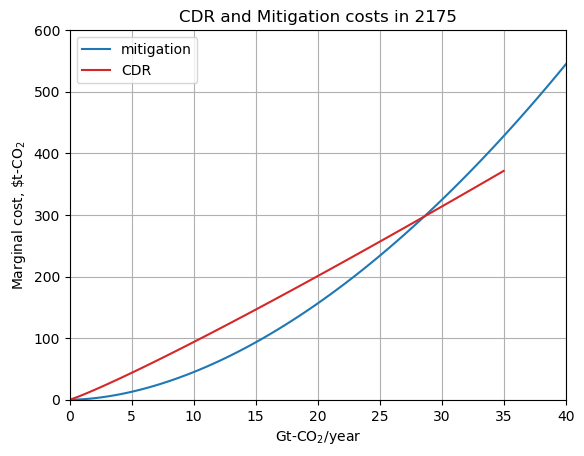

In [23]:
α = collect(0:0.01:1.)
function marginal_cost_M(year)
    yearidx = t(params) .== year
    return (
        (10^12 * E(params)[yearidx]*params.economics.mitigate_cost .* α.^1.8) /
        ppm_to_tCO2(params.economics.baseline_emissions)[yearidx]
    )
end

function marginal_cost_R(year)
    yearidx = t(params) .== year
    return (
        (10^12 * params.economics.remove_cost .* α.^1.1) /
        ppm_to_tCO2(params.economics.baseline_emissions[1])
    )
end

for year in [2175.]   
    plot(ppm_to_GtCO2(params.economics.baseline_emissions[1])*α*1.5, marginal_cost_M(year), "C0-", label="mitigation")
    plot(ppm_to_GtCO2(params.economics.baseline_emissions[1])*α, marginal_cost_R(year), "C3-", label="CDR")
end
legend()
title("CDR and Mitigation costs in 2175")
xlim([0,40])
ylim([0, 600])
xlabel(L"Gt-CO$_{2}$/year")
ylabel(L"Marginal cost, \$t-CO$_{2}$")
grid(true)
savefig("figures/replicate_Belaia_et_al_2020_Figure2.png", dpi=150., bbox_inches="tight")

#### Figure 3b

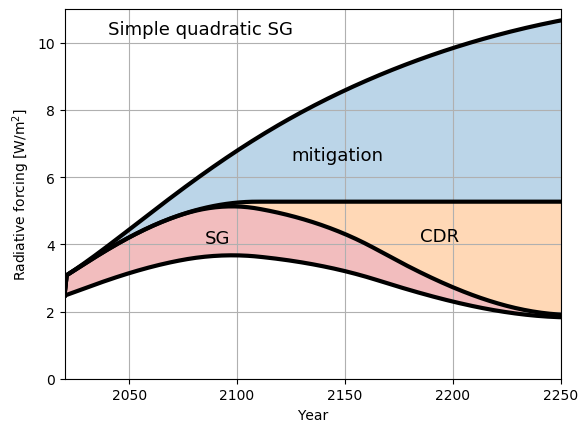

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
F0 = 3.0
fill_between(t(params), F(Belaia, F0=F0), F(Belaia, M=true, F0=F0), facecolor="C0", alpha=0.3)
fill_between(t(params), F(Belaia, M=true, F0=F0), F(Belaia, M=true, R=true, F0=F0), facecolor="C1", alpha=0.3)
fill_between(t(params), F(Belaia, M=true, R=true, F0=F0), F(Belaia, M=true, R=true, G=true, F0=F0), facecolor="C3", alpha=0.3)
plot(t(params), F(Belaia, F0=F0), "k-", lw=3)
plot(t(params), F(Belaia, M=true, F0=F0), "k-", lw=3)
plot(t(params), F(Belaia, M=true, R=true, F0=F0), "k-", lw=3)
plot(t(params), F(Belaia, M=true, R=true, G=true, F0=F0), "k-", lw=3)
ylim([0, 11])
xlim([2020, 2250])
ylabel(L"Radiative forcing [W/m$^2$]")
xlabel("Year")
grid(true)

annotate(s="mitigation", xy=(2125, 6.5), fontsize=13)
annotate(s="CDR", xy=(2185, 4.1), fontsize=13)
annotate(s="SG", xy=(2085, 4.05), fontsize=13)
annotate(s="Simple quadratic SG", xy=(2040, 10.25), fontsize=13)

savefig("figures/replicate_Belaia_et_al_2020_Figure3b.eps", dpi=200., bbox_inches="tight")

In [25]:
println("All results reported in trillions of USD.")

for ρ in [0.015, 0.03]
    println("ρ = $(ρ*100) discount rate")
    for (model, modelname) in zip([Belaia, Belaia_MR], ["MRG", "MR"])
        println("  Allowed controled: $(modelname)")
        model.economics.ρ = ρ
        println("    Integrated discounted control costs = $(round(sum(cost(model, discounting=true, M=true, R=true, G=true))))")
        println("    Integrated discounted controlled damages = $(round(sum(damage(model, discounting=true, M=true, R=true, G=true))))")
        net_costs = sum(cost(model, discounting=true, M=true, R=true, G=true) .+ damage(model, discounting=true, M=true, R=true, G=true))
        println("    Total integrated discounted costs (controls + damages) = $(round(net_costs))")
        println("    Integrated discounted baseline damages = $(round(sum(damage(model, discounting=true))))")
        println("    Net present benefits (cost + damage) relative to baseline damages = $(round(net_present_benefit(model, discounting=true, M=true, R=true, G=true)))")
    end
end

All results reported in trillions of USD.
ρ = 1.5 discount rate
  Allowed controled: MRG
    Integrated discounted control costs = 238.0
    Integrated discounted controlled damages = 106.0
    Total integrated discounted costs (controls + damages) = 344.0
    Integrated discounted baseline damages = 26056.0
    Net present benefits (cost + damage) relative to baseline damages = 25712.0
  Allowed controled: MR
    Integrated discounted control costs = 213.0
    Integrated discounted controlled damages = 219.0
    Total integrated discounted costs (controls + damages) = 432.0
    Integrated discounted baseline damages = 26057.0
    Net present benefits (cost + damage) relative to baseline damages = 25625.0
ρ = 3.0 discount rate
  Allowed controled: MRG
    Integrated discounted control costs = 54.0
    Integrated discounted controlled damages = 32.0
    Total integrated discounted costs (controls + damages) = 86.0
    Integrated discounted baseline damages = 528.0
    Net present benefi